# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# from unityagents import UnityEnvironment
# import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
# env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# # get the default brain
# brain_name = env.brain_names[0]
# brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# # reset the environment
# env_info = env.reset(train_mode=True)[brain_name]

# # number of agents 
# num_agents = len(env_info.agents)
# print('Number of agents:', num_agents)

# # size of each action
# action_size = brain.vector_action_space_size
# print('Size of each action:', action_size)

# # examine the state space 
# states = env_info.vector_observations
# state_size = states.shape[1]
# print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
# for i in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
import os
from collections import deque
from typing import Deque, List

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
from unityagents import UnityEnvironment

from agent import Agent
from agent_manager import AgentManager

Device cuda is currently used.


In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
num_stacked_observations = brain.num_stacked_vector_observations
observation_space_size = brain.vector_observation_space_size
state_size = num_stacked_observations * observation_space_size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [10]:
def train_with_agent_manager(
    env,
    brain_name: str,
    agent_manager: AgentManager,
    n_episodes: int = 10000,
    max_timestamp_per_episode: int = 100,
    num_timestamp_per_print: int = 100,
) -> List[float]:
    scores_window = deque(maxlen=num_timestamp_per_print)
    scores_by_episode = []

    is_problem_solved = False
    for episode_idx in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent_states = env_info.vector_observations
        agent_manager.noise.reset()
        agent_scores = np.zeros(num_agents)

        timestamp = 0
        while True:
            timestamp += 1
            agent_actions = agent_manager.act(agent_states)
            env_info = env.step(agent_actions)[brain_name]
            agent_next_states, agent_rewards, agent_dones = (
                env_info.vector_observations,
                env_info.rewards,
                env_info.local_done,
            )

            agent_manager.step(
                agent_states,
                agent_actions,
                agent_rewards,
                agent_next_states,
                agent_dones,
                timestamp,
            )

            agent_states = agent_next_states
            agent_scores += agent_rewards
            if np.any(agent_dones):
                break

        max_score_by_episode = np.max(agent_scores)
        scores_window.append(max_score_by_episode)
        scores_by_episode.append(max_score_by_episode)
        average_score = np.mean(scores_window)

        print(
            f"\rEpisode {episode_idx}\t"
            f"\tMax score: {max_score_by_episode:.4f}\t"
            f"\tAverage score: {average_score:.4f}",
            end="",
        )
        
        if episode_idx % num_timestamp_per_print == 0:
            print(
                f"\rEpisode {episode_idx}"
                f"\tMax score: {max_score_by_episode:.4f}"
                f"\tAverage score: {average_score:.4f}"
            )

        if average_score >= 0.5:
            if not is_problem_solved:
                is_problem_solved = True
                print(f"\nProblem solved within {episode_idx} episodes.")
                return scores_by_episode
            
        # Update the noise scaler
        agent_manager.noise.step()
    
    return scores_by_episode

In [11]:
def draw_scores(scores: List[float]) -> None:
    fig = plt.figure(figsize=(12, 8))
    plt.plot(scores)
    plt.ylabel('Average score')
    plt.xlabel('Number of episodes')
    plt.show()

Episode 100	Max score: 0.0000	Average score: 0.005757
Episode 200	Max score: 0.0000	Average score: 0.000000
Episode 300	Max score: 0.0000	Average score: 0.000000
Episode 400	Max score: 0.0000	Average score: 0.004040
Episode 500	Max score: 0.0000	Average score: 0.000909
Episode 600	Max score: 0.0000	Average score: 0.023030
Episode 700	Max score: 0.0900	Average score: 0.034040
Episode 800	Max score: 0.0900	Average score: 0.079494
Episode 900	Max score: 0.1000	Average score: 0.091313
Episode 1000	Max score: 0.1000	Average score: 0.095050
Episode 1100	Max score: 0.1000	Average score: 0.098888
Episode 1200	Max score: 0.1000	Average score: 0.119292
Episode 1300	Max score: 0.2900	Average score: 0.127777
Episode 1400	Max score: 0.3900	Average score: 0.150101
Episode 1500	Max score: 0.1000	Average score: 0.175050
Episode 1600	Max score: 0.2000	Average score: 0.162424
Episode 1700	Max score: 0.2000	Average score: 0.251919
Episode 1786		Max score: 2.6000		Average score: 0.5081
Problem solved with

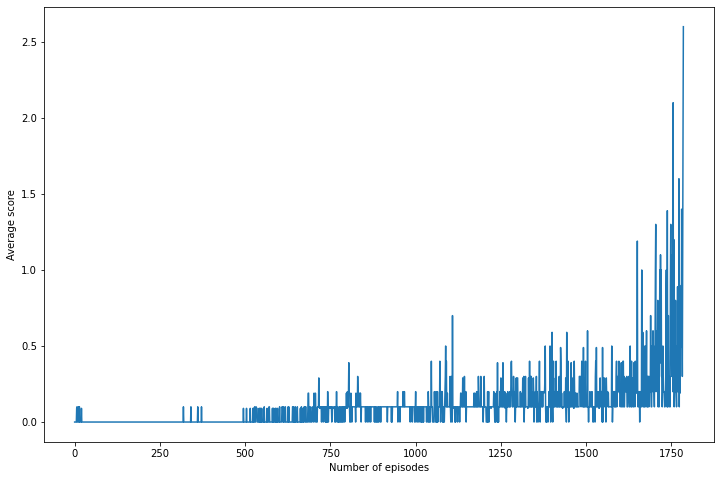

In [12]:
OVERWRITE = True
ACTOR_MODEL_FILE_PATH = "maddpg_actor_local_{agent_idx}.pt"
CRITIC_MODEL_FILE_PATH = "maddpg_critic_local_{agent_idx}.pt"

agent_manager = AgentManager(
    num_agents,
    state_size=state_size,
    action_size=action_size,
    seed=514,
)

# Check if model is cached
is_cached = not OVERWRITE
for agent_idx in range(num_agents):
    actor_model_file_path = ACTOR_MODEL_FILE_PATH.format(agent_idx=agent_idx)
    critic_model_file_path = CRITIC_MODEL_FILE_PATH.format(agent_idx=agent_idx)
    is_cached = (
        is_cached
        and os.path.exists(actor_model_file_path)
        and os.path.exists(critic_model_file_path)
    )

if is_cached:
    for agent_idx, agent in enumerate(agent_manager.agents):
        actor_model_file_path = ACTOR_MODEL_FILE_PATH.format(agent_idx=agent_idx)
        critic_model_file_path = CRITIC_MODEL_FILE_PATH.format(agent_idx=agent_idx)
        agent.actor_local.load_state_dict(torch.load(ACTOR_MODEL_FILE_PATH))
        agent.critic_local.load_state_dict(torch.load(CRITIC_MODEL_FILE_PATH))
else:
    scores_by_episode = train_with_agent_manager(env, brain_name, agent_manager)
    for agent_idx, agent in enumerate(agent_manager.agents):
        actor_model_file_path = ACTOR_MODEL_FILE_PATH.format(agent_idx=agent_idx)
        critic_model_file_path = CRITIC_MODEL_FILE_PATH.format(agent_idx=agent_idx)
        torch.save(agent.actor_local.state_dict(), actor_model_file_path)
        torch.save(agent.critic_local.state_dict(), critic_model_file_path)
    draw_scores(scores_by_episode)

In [13]:
env.close()